## Hoang Khang Pham - 126459239
## Minh Tan To

# Import Libraries

In [38]:
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.cluster import KMeans, AgglomerativeClustering
from sklearn.mixture import GaussianMixture
from sklearn.metrics import silhouette_score, davies_bouldin_score, calinski_harabasz_score
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import Pipeline


# Prepare dataset

## Import dataset


In [39]:
df = pd.read_csv("CC GENERAL.csv", nrows=5000)

## Handle missing values

In [40]:
df.isnull().sum()

CUST_ID                               0
BALANCE                               0
BALANCE_FREQUENCY                     0
PURCHASES                             0
ONEOFF_PURCHASES                      0
INSTALLMENTS_PURCHASES                0
CASH_ADVANCE                          0
PURCHASES_FREQUENCY                   0
ONEOFF_PURCHASES_FREQUENCY            0
PURCHASES_INSTALLMENTS_FREQUENCY      0
CASH_ADVANCE_FREQUENCY                0
CASH_ADVANCE_TRX                      0
PURCHASES_TRX                         0
CREDIT_LIMIT                          0
PAYMENTS                              0
MINIMUM_PAYMENTS                    160
PRC_FULL_PAYMENT                      0
TENURE                                0
dtype: int64

In [41]:
df['MINIMUM_PAYMENTS'].fillna(df['MINIMUM_PAYMENTS'].median(), inplace=True)
df.drop('CUST_ID', axis=1, inplace=True)

C:\Users\tomin\AppData\Local\Temp\ipykernel_9964\3618717446.py:1: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df['MINIMUM_PAYMENTS'].fillna(df['MINIMUM_PAYMENTS'].median(), inplace=True)


## Frame the Problem & Train/Test Split
- Define your unsupervised objective (e.g., customer segments, usage patterns).
    - identify customer segments based on their credit card usage patterns — such as spending habits, cash advances, payments, and credit limits.
- Identify features (no explicit target).
- Create three splits: train_size = {0.10, 0.25, 0.30}.
- Keep the test set unseen until final evaluation

In [42]:
X = df
train_size = {0.10, 0.25, 0.30}
for size in train_size:
    X_train, X_test = train_test_split(X, test_size=size, random_state=42)
    print(f"Train size: {X_train.shape}, Test size: {X_test.shape} for test_size={size}")




Train size: (4500, 17), Test size: (500, 17) for test_size=0.1
Train size: (3750, 17), Test size: (1250, 17) for test_size=0.25
Train size: (3500, 17), Test size: (1500, 17) for test_size=0.3


# EDA (Exploratory Data Analysis)
- head(), info(), shape, missing counts.
- Histograms & boxplots for distribution.
- Correlation heatmap to spot redundant features.

In [43]:
print(df.head())
print(df.info())
print(df.shape)
print(df.isnull().sum())

       BALANCE  BALANCE_FREQUENCY  PURCHASES  ONEOFF_PURCHASES  \
0    40.900749           0.818182      95.40              0.00   
1  3202.467416           0.909091       0.00              0.00   
2  2495.148862           1.000000     773.17            773.17   
3  1666.670542           0.636364    1499.00           1499.00   
4   817.714335           1.000000      16.00             16.00   

   INSTALLMENTS_PURCHASES  CASH_ADVANCE  PURCHASES_FREQUENCY  \
0                    95.4      0.000000             0.166667   
1                     0.0   6442.945483             0.000000   
2                     0.0      0.000000             1.000000   
3                     0.0    205.788017             0.083333   
4                     0.0      0.000000             0.083333   

   ONEOFF_PURCHASES_FREQUENCY  PURCHASES_INSTALLMENTS_FREQUENCY  \
0                    0.000000                          0.083333   
1                    0.000000                          0.000000   
2                

## Histograms & Boxplots

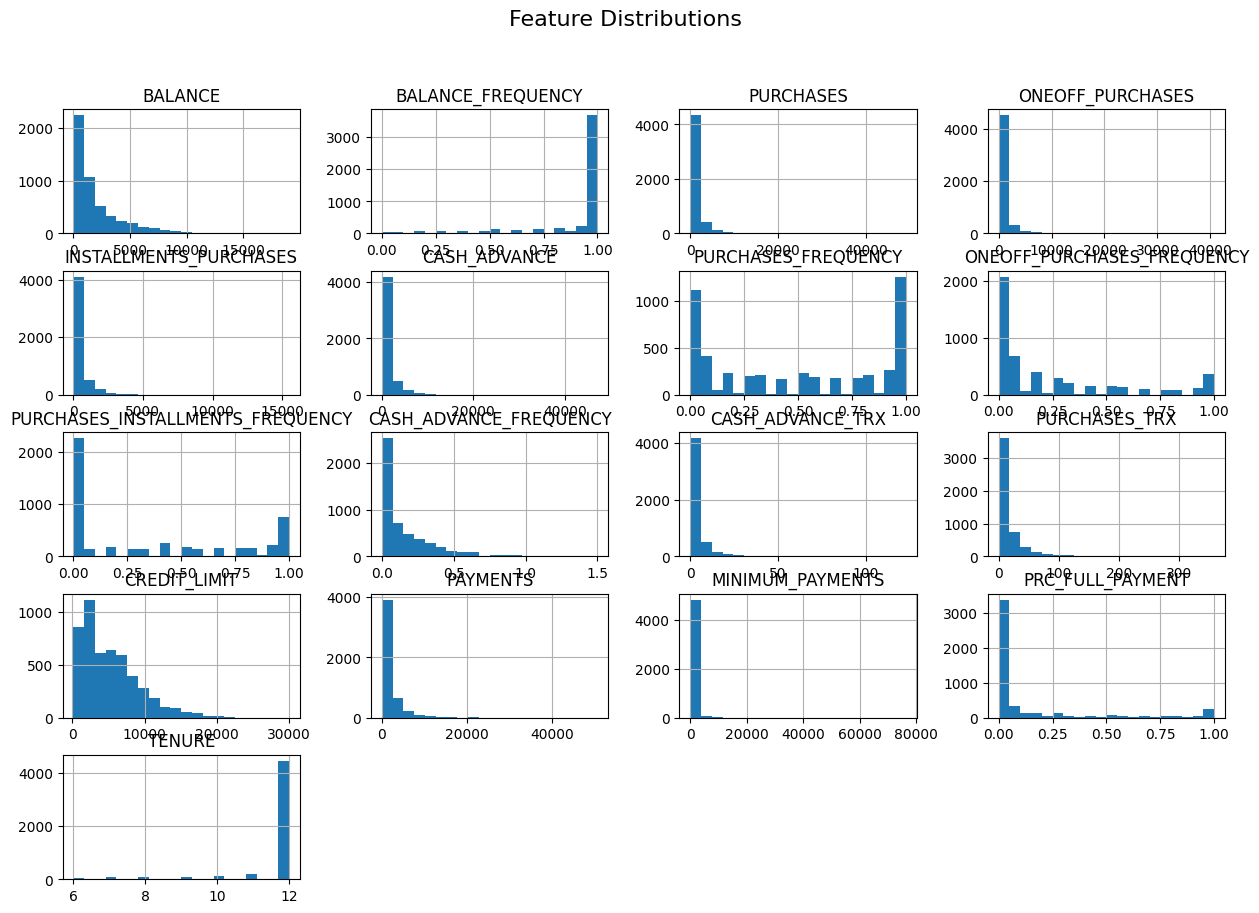

In [44]:

df.hist(figsize=(15, 10), bins=20)
plt.suptitle("Feature Distributions", fontsize=16)
plt.show()


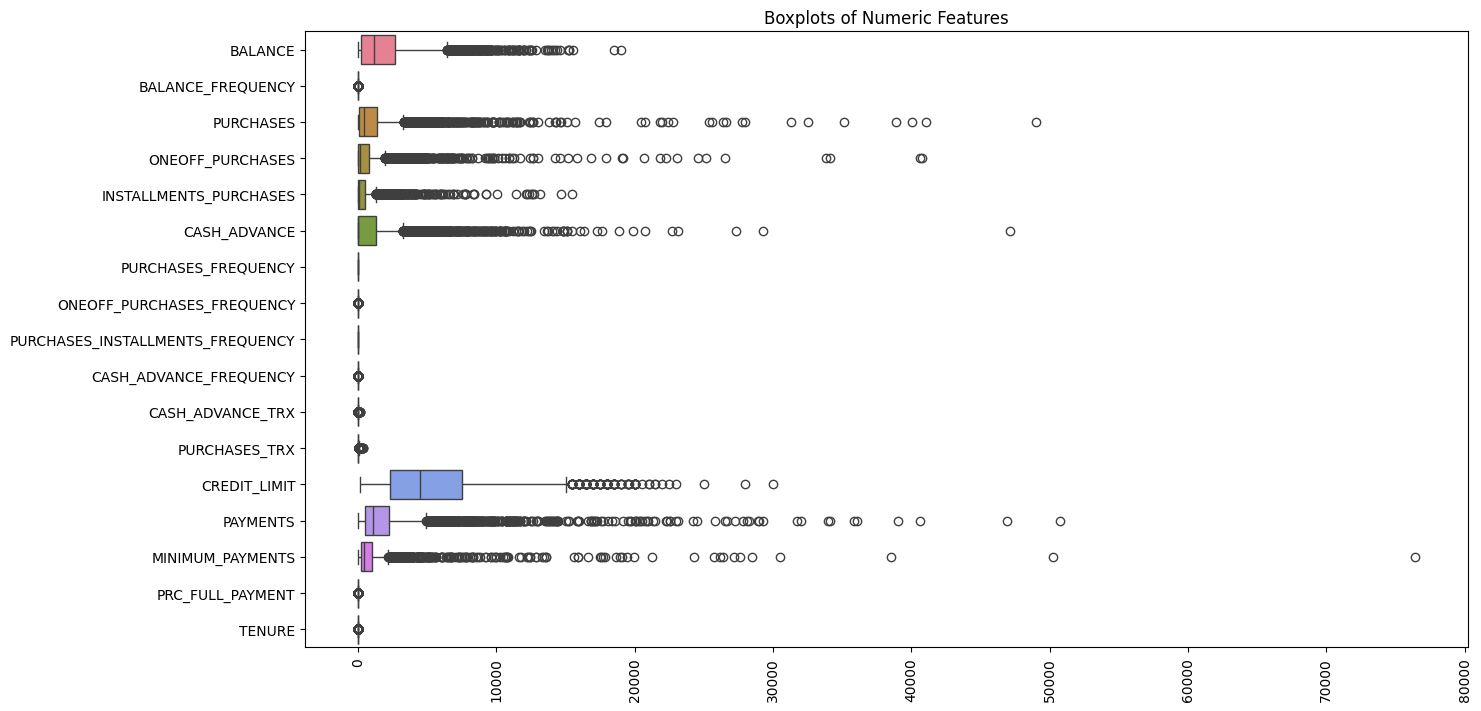

In [45]:

plt.figure(figsize=(15, 8))
sns.boxplot(data=df, orient="h")
plt.xticks(rotation=90)
plt.title("Boxplots of Numeric Features")
plt.show()


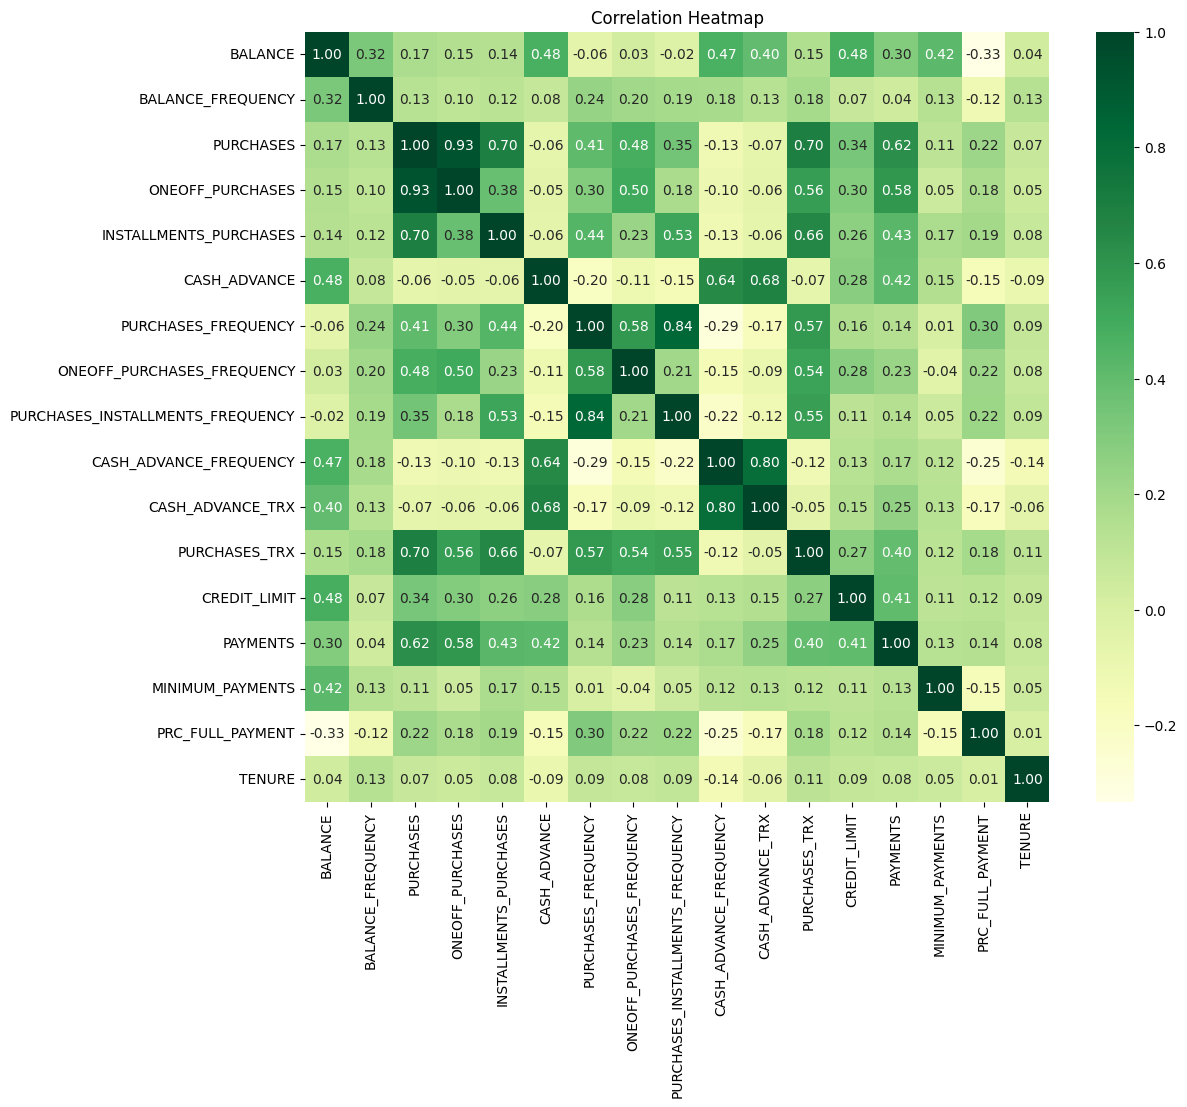

In [46]:
plt.figure(figsize =(12,10))
sns.heatmap(df.corr(), annot = True, cmap ="YlGn", fmt='.2f')
plt.title("Correlation Heatmap")
plt.show()

# Categorical Handling
- Detect categorical columns.
- Apply One-Hot Encoding or Ordinal Encoding (briefly justify choice).

#### DATA đéo có cat columns nên đéo có encode


In [47]:
cat_col = df.select_dtypes(include=['object']).columns.tolist()
print("Categorical columns:", cat_col)
num_col = df.select_dtypes(include=['int64', 'float64']).columns.tolist()
print("Numerical columns:", num_col)


Categorical columns: []
Numerical columns: ['BALANCE', 'BALANCE_FREQUENCY', 'PURCHASES', 'ONEOFF_PURCHASES', 'INSTALLMENTS_PURCHASES', 'CASH_ADVANCE', 'PURCHASES_FREQUENCY', 'ONEOFF_PURCHASES_FREQUENCY', 'PURCHASES_INSTALLMENTS_FREQUENCY', 'CASH_ADVANCE_FREQUENCY', 'CASH_ADVANCE_TRX', 'PURCHASES_TRX', 'CREDIT_LIMIT', 'PAYMENTS', 'MINIMUM_PAYMENTS', 'PRC_FULL_PAYMENT', 'TENURE']


# Custom Feature Engineering
- Add ≥ 1 new feature (e.g., ratio, grouped mean).
- Implement as FunctionTransformer or custom BaseEstimator.

- TOTAL_PURCHASES_VALUE
- AVG_PURCHASE_AMOUNT
- PURCHASE_RATIO
- CASH_TO_PURCHASES
- CASH_ADVANCE_PER_TRX
- BALANCE_LIMIT_RATIO
- PAY_MIN_RATIO
- PAY_BALANCE_RATIO
- PURCHASE_BEHAVIOR_SCORE
- IS_FULL_PAYER

In [ ]:

from sklearn.compose import ColumnTransformer
class AddFeatures(BaseEstimator, TransformerMixin):
    def __init__(self):
        pass
    def fit(self, X, y=None):
        return self
    def add_features(self, X):
        df = X.copy()
         # 1. Tổng giá trị mua
        df['TOTAL_PURCHASES_VALUE'] = (df['ONEOFF_PURCHASES'] +df['INSTALLMENTS_PURCHASES'])
        # 2. Giá trị trung bình mỗi lần mua
        df['AVG_PURCHASE_AMOUNT'] = (df['TOTAL_PURCHASES_VALUE'] / (df['PURCHASES_TRX'] + 1))
        # 3. Tỷ lệ mua 1 lần / trả góp
        df['PURCHASE_RATIO'] = (df['ONEOFF_PURCHASES'] / (df['INSTALLMENTS_PURCHASES'] + 1))
        # 4. Tỷ lệ rút tiền mặt / tổng mua
        df['CASH_TO_PURCHASES'] = (df['CASH_ADVANCE'] / (df['TOTAL_PURCHASES_VALUE'] + 1))
        # 5. Rút tiền mặt trung bình mỗi giao dịch
        df['CASH_ADVANCE_PER_TRX'] = (df['CASH_ADVANCE'] / (df['CASH_ADVANCE_TRX'] + 1))
        # 6. Tỷ lệ sử dụng hạn mức
        df['BALANCE_LIMIT_RATIO'] = (df['BALANCE'] / (df['CREDIT_LIMIT'] + 1))
        # 7. Payment / Minimum Payment
        df['PAY_MIN_RATIO'] = (df['PAYMENTS'] / (df['MINIMUM_PAYMENTS'] + 1))
        # 8. Payment / Balance
        df['PAY_BALANCE_RATIO'] = (df['PAYMENTS'] / (df['BALANCE'] + 1))
        # 9. Điểm hành vi mua
        df['PURCHASE_BEHAVIOR_SCORE'] = (df['PURCHASES_FREQUENCY'] + df['ONEOFF_PURCHASES_FREQUENCY'] + df['PURCHASES_INSTALLMENTS_FREQUENCY'])
        # 10. Full payment flag
        df['IS_FULL_PAYER'] = (df['PRC_FULL_PAYMENT'] > 0.5).astype(int)
        return df

    def transform(self, X):
        return self.add_features(X)

    



(5000, 27)

# Pipelines
- Create a ColumnTransformer + Pipeline including:
    - Encoder (for categoricals)
    - Scaler (for numerics)
    - Placeholder for model
Use fit() on train only and transform() on test.

In [ ]:
full_cols = num_col + ['TOTAL_PURCHASES_VALUE','AVG_PURCHASE_AMOUNT','PURCHASE_RATIO','CASH_TO_PURCHASES','CASH_ADVANCE_PER_TRX','BALANCE_LIMIT_RATIO','PAY_MIN_RATIO','PAY_BALANCE_RATIO','PURCHASE_BEHAVIOR_SCORE','IS_FULL_PAYER']

num_pipeline = Pipeline([
    ("scaler", StandardScaler())
])

preprocess = Pipeline([
    ("custom", AddFeatures()),
    ("preprocessor", ColumnTransformer([
        ("nums", num_pipeline, full_cols)
    ]))
])

processed_data = preprocess.fit_transform(X)
processed_data.shape

In [49]:
def compute_cluster_metrics(X_train, train_labels, X_test, test_labels):
    return {
        "train_sil": silhouette_score(X_train, train_labels),
        "train_dbi": davies_bouldin_score(X_train, train_labels),
        "train_ch": calinski_harabasz_score(X_train, train_labels),
        
        "test_sil": silhouette_score(X_test, test_labels),
        "test_dbi": davies_bouldin_score(X_test, test_labels),
        "test_ch": calinski_harabasz_score(X_test, test_labels),
    }

# Model Training & Evaluation

# k-mean

In [50]:
k_mean_results = []
test_sizes = [0.90, 0.75, 0.70]
n_clusters_list = [3, 5, 7, 9]
n_init_list = [10, 20, 50]
max_iter_list = [100, 300, 600]
for test_size in test_sizes:
        X_train, X_test = train_test_split(processed_data, test_size=test_size, random_state=42)
        for k in n_clusters_list:
            for n_init in n_init_list:
                for max_iter in max_iter_list:

                    kmeans = KMeans(n_clusters=k,n_init=n_init,max_iter=max_iter,random_state=42)

                    train_labels = kmeans.fit_predict(X_train)
                    test_labels = kmeans.predict(X_test)

                    metrics = compute_cluster_metrics(X_train, train_labels, X_test, test_labels)

                    k_mean_results.append({
                        "model": "KMeans",
                        "train_size": 1-test_size,
                        "n_clusters": k,
                        "params": f"n_init={n_init}, max_iter={max_iter}",
                        **metrics
                    })

# agglomerative

In [ ]:
agglomerative_results = []
for test_size in test_sizes:
    X_train , X_test = train_test_split(processed_data, test_size=test_size, random_state=42)
    for n in n_clusters_list:
        agg = AgglomerativeClustering(n_clusters=n)
        train_labels = agg.fit_predict(X_train)
        test_labels = agg.fit_predict(X_test)
        metrics = compute_cluster_metrics(X_train, train_labels, X_test, test_labels)

        agglomerative_results.append({
            "model": "Agglomerative",
            "train_size": 1-test_size,
            "n_clusters": k,
            "params": "None",
            **metrics
            })

# GMM

In [54]:
gmm_results = []
for test_size in test_sizes:
    X_train, X_test = train_test_split(processed_data, test_size=test_size, random_state=42)
    for k in n_clusters_list:
        for max_iter in max_iter_list:
            gmm = GaussianMixture(n_components=k,max_iter=max_iter,random_state=42)
            train_labels = agg.fit_predict(X_train)
            test_labels = agg.fit_predict(X_test)
            metrics = compute_cluster_metrics(X_train, train_labels, X_test, test_labels)

            gmm_results.append({
                "model": "GMM",
                "train_size": 1-test_size,
                "n_clusters": k,
                "params": f"max_iter={max_iter}",
                **metrics
            })

# Export to csv

In [61]:
all_results = (k_mean_results + agglomerative_results + gmm_results)

df_results = pd.DataFrame(all_results)
df_results.to_csv("clustering_results.csv", index=False)
df_results.head()

,model,train_size,n_clusters,params,train_sil,train_dbi,train_ch,test_sil,test_dbi,test_ch
0,KMeans,0.1,3,"n_init=10, max_iter=100",0.197943,1.732695,87.505154,0.191513,1.775932,626.183145
1,KMeans,0.1,3,"n_init=10, max_iter=300",0.197943,1.732695,87.505154,0.191513,1.775932,626.183145
2,KMeans,0.1,3,"n_init=10, max_iter=600",0.197943,1.732695,87.505154,0.191513,1.775932,626.183145
3,KMeans,0.1,3,"n_init=20, max_iter=100",0.196337,1.731307,87.545248,0.190740,1.773899,625.330894
4,KMeans,0.1,3,"n_init=20, max_iter=300",0.196337,1.731307,87.545248,0.190740,1.773899,625.330894


In [62]:
df_results["score"] = (
    df_results["train_sil"] + df_results["test_sil"]
    - df_results["train_dbi"] - df_results["test_dbi"]
    + df_results["train_ch"] + df_results["test_ch"]
)
df_results.head()

,model,train_size,n_clusters,params,train_sil,train_dbi,train_ch,test_sil,test_dbi,test_ch,score
0,KMeans,0.1,3,"n_init=10, max_iter=100",0.197943,1.732695,87.505154,0.191513,1.775932,626.183145,710.569128
1,KMeans,0.1,3,"n_init=10, max_iter=300",0.197943,1.732695,87.505154,0.191513,1.775932,626.183145,710.569128
2,KMeans,0.1,3,"n_init=10, max_iter=600",0.197943,1.732695,87.505154,0.191513,1.775932,626.183145,710.569128
3,KMeans,0.1,3,"n_init=20, max_iter=100",0.196337,1.731307,87.545248,0.190740,1.773899,625.330894,709.758013
4,KMeans,0.1,3,"n_init=20, max_iter=300",0.196337,1.731307,87.545248,0.190740,1.773899,625.330894,709.758013


In [63]:
best_row = df_results.loc[df_results["score"].idxmax()]
print("Best Model:\n", best_row)

Best Model:
 model                          KMeans
train_size                       0.25
n_clusters                          3
params        n_init=10, max_iter=100
train_sil                    0.198786
train_dbi                    1.595624
train_ch                   220.966364
test_sil                     0.193396
test_dbi                     1.673663
test_ch                    512.278652
score                      730.367911
Name: 36, dtype: object
